In [ ]:
# --- CELL 1: SETUP & INGESTION ---
import os

# 1. CRITICAL: Prevent JAX from locking all VRAM immediately
# This allows us to coexist with the download process and saving routine
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90" # Leave 10% for system overhead

# 2. Install Dependencies
!pip install -q -U jax[cuda12] flax optax kagglehub safetensors

import jax
import jax.numpy as jnp
from jax import random, lax
import numpy as np
import kagglehub
from safetensors.flax import load_file
import matplotlib.pyplot as plt
import gc

print(f"Device detected: {jax.devices()[0]}")

# 3. Download Model Weights (DeepSeek-R1-Distill-Llama-8B)
# This will download to a local cache folder in Colab
print("Downloading DeepSeek R1 Weights from Kaggle...")
model_path = kagglehub.model_download("deepseek-ai/deepseek-r1/Transformers/deepseek-r1-distill-llama-8b/2")

print(f"\nModel downloaded to: {model_path}")

# Identify the shard containing Layer 15 (Usually shard 3 or 4 for 8B models, but we check map)
# For Llama-3-8B architectures, layer 15 is typically in the middle shards.
# We will check file contents dynamically in the next cell.


Device detected: cuda:0



100%|██████████| 14.2k/14.2k [00:00<00:00, 11.6MB/s]



100%|██████████| 1.04k/1.04k [00:00<00:00, 1.25MB/s]

100%|██████████| 181/181 [00:00<00:00, 131kB/s]




  0%|          | 0.00/759k [00:00<?, ?B/s]
  0%|          | 0.00/1.48k [00:00<?, ?B/s]


100%|██████████| 1.48k/1.48k [00:00<00:00, 782kB/s]
100%|██████████| 826/826 [00:00<00:00, 427kB/s]



  0%|          | 0.00/8.07G [00:00<?, ?B/s]




  0%|          | 0.00/6.89G [00:00<?, ?B/s]





100%|██████████| 23.7k/23.7k [00:00<00:00, 1.97MB/s]






  0%|          | 0.00/8.66M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
 44%|████▍     | 3.02G/6.89G [03:12<04:12, 16.5MB/s]
 37%|███▋      | 2.99G/8.07G [03:12<05:23, 16.9MB/s]


 44%|████▍     | 3.03G/6.89G [03:12<04:00, 17.2MB/s]
 37%|███▋      | 3.00G/8.07G [03:12<05:29, 16.5MB/s]
 37%|███▋      | 3.00G/8.07G [03:12<04:46, 19.0MB/s]


 44%|████▍     | 3.03G/6.89G [03:12<04:07, 16.8MB/s]
 37%|███▋      | 3.00G/8.07G [03:12<05:27, 16.6MB/s]


 44%|████▍     | 3.03G/6.89G [03:12<03:57, 17.4MB/s]
 37%|███▋      | 3.00G/8.07G [03:13<05:17, 17.2MB/s]


 44%|████▍     | 3.04G/6.89G [03:13<03:50, 17.9MB/s]
 37%|███▋      | 3.01G/8.07G [03:13<05:26, 16.7MB/s]
 37%|███▋      | 3.01G/8.07G [03:13<04:41, 19.3MB/s]


 44%|████▍     | 3.04G/6.89G [03:13<03:59, 17.2MB/s]
 37%|███▋      | 3.01G/8.07G [03:13<05:02, 18.0MB/s]


 44%|████▍     | 3.04G/6.89G [03:13<03:52, 17.8MB/s]
 37%|███▋      | 3.01G/8.07G [03:13<05:21, 16.9MB/s]


 44%|████▍     | 3.05G/6.89G [03:13<03:47, 18.1MB/s]
 37%|███▋      | 3.02G/8.07G [03:1


Model downloaded to: /root/.cache/kagglehub/models/deepseek-ai/deepseek-r1/Transformers/deepseek-r1-distill-llama-8b/2


In [ ]:
# --- CELL 2: THE A100 ISING KERNEL ---

@jax.jit
def calculate_local_field(spins, external_field, coupling_j):
    """
    Computes the effective local field acting on each spin.
    Local Field = h_i (weight magnitude) + J * sum(neighbor_spins)
    """
    # Toroidal boundary conditions (wrap-around)
    # This creates the 'topology' of the lattice
    neighbors = (
        jnp.roll(spins, 1, axis=0) +
        jnp.roll(spins, -1, axis=0) +
        jnp.roll(spins, 1, axis=1) +
        jnp.roll(spins, -1, axis=1)
    )
    return external_field + (coupling_j * neighbors)

@jax.jit
def metropolis_step_checkerboard(key, spins, external_field, coupling_j, temp):
    """
    Parallel Metropolis-Hastings update using Checkerboard decomposition.
    """
    rows, cols = spins.shape

    # Create checkerboard mask (0 and 1)
    i_idx, j_idx = jnp.meshgrid(jnp.arange(rows), jnp.arange(cols), indexing='ij')
    checkerboard = (i_idx + j_idx) % 2

    def update_phase(current_spins, phase_key, phase_mask):
        # Calculate energy cost of flipping
        local_field = calculate_local_field(current_spins, external_field, coupling_j)

        # dE = Energy_after - Energy_before
        # Since s_new = -s_old, dE = 2 * s_old * Local_Field
        # (Positive dE means flipping increases energy -> bad)
        dE = 2.0 * current_spins * local_field

        # Metropolis criterion
        # Accept if dE < 0 OR random < exp(-dE/T)
        probability = jnp.exp(-dE / temp)
        random_vals = random.uniform(phase_key, shape=current_spins.shape)

        should_flip = (dE < 0) | (random_vals < probability)

        # Apply flips only to the current checkerboard phase
        return jnp.where(phase_mask & should_flip, -current_spins, current_spins)

    # Split key for two phases
    k1, k2 = random.split(key)

    # Phase 0 (Black squares)
    spins = update_phase(spins, k1, checkerboard == 0)

    # Phase 1 (White squares)
    spins = update_phase(spins, k2, checkerboard == 1)

    return spins

def anneal_layer(weights, steps=2000, t_start=5.0, t_end=0.01, coupling=0.6):
    """
    Main Annealing Loop.
    coupling=0.6 enforces strong clustering (The 'Ising Landscape').
    """
    print(f"Loading Lattice: {weights.shape} | Device: {weights.device}")

    # 1. Setup External Field (The 'Intelligence')
    # Normalize weights to [-1, 1] based on magnitude
    # Strong weights -> Strong preference to stay (+1)
    # Weak weights -> Preference to flip/prune (-1)
    mag = jnp.abs(weights)
    field = (mag - jnp.mean(mag)) / jnp.std(mag)

    # 2. Initialize Spins (Random Start)
    key = random.PRNGKey(42)
    spins = random.choice(key, jnp.array([-1.0, 1.0]), shape=weights.shape)

    # 3. Temperature Schedule
    temps = jnp.linspace(t_start, t_end, steps)

    # 4. The Loop
    print(f"Annealing for {steps} steps on A100...")

    # We use a simple Python loop because JIT compiles the heavy lifting inside 'step_fn'
    # This lets us print progress easily.
    step_fn = metropolis_step_checkerboard

    for i, t in enumerate(temps):
        key, subkey = random.split(key)
        spins = step_fn(subkey, spins, field, coupling, t)

        if i % 200 == 0:
            sparsity = jnp.mean(spins == -1)
            print(f"Step {i:04d} | Temp: {t:.4f} | Pruned: {sparsity:.2%}")

    return spins, field


Searching for: model.layers.15.mlp.up_proj.weight...
Found in: model-00001-of-000002.safetensors
Starting Annealing on (14336, 4096)...
Loading Lattice: (14336, 4096) | Device: cuda:0
Annealing for 2500 steps on A100...
Step 0000 | Temp: 5.0000 | Pruned: 50.42%
Step 0200 | Temp: 4.6006 | Pruned: 50.24%
Step 0400 | Temp: 4.2013 | Pruned: 50.34%
Step 0600 | Temp: 3.8019 | Pruned: 50.51%
Step 0800 | Temp: 3.4026 | Pruned: 50.76%
Step 1000 | Temp: 3.0032 | Pruned: 51.21%
Step 1200 | Temp: 2.6038 | Pruned: 51.98%
Step 1400 | Temp: 2.2045 | Pruned: 53.38%
Step 1600 | Temp: 1.8051 | Pruned: 55.91%
Step 1800 | Temp: 1.4058 | Pruned: 59.72%
Step 2000 | Temp: 1.0064 | Pruned: 63.28%
Step 2200 | Temp: 0.6070 | Pruned: 65.08%
Step 2400 | Temp: 0.2077 | Pruned: 65.58%

FINAL SPARSITY: 65.58%


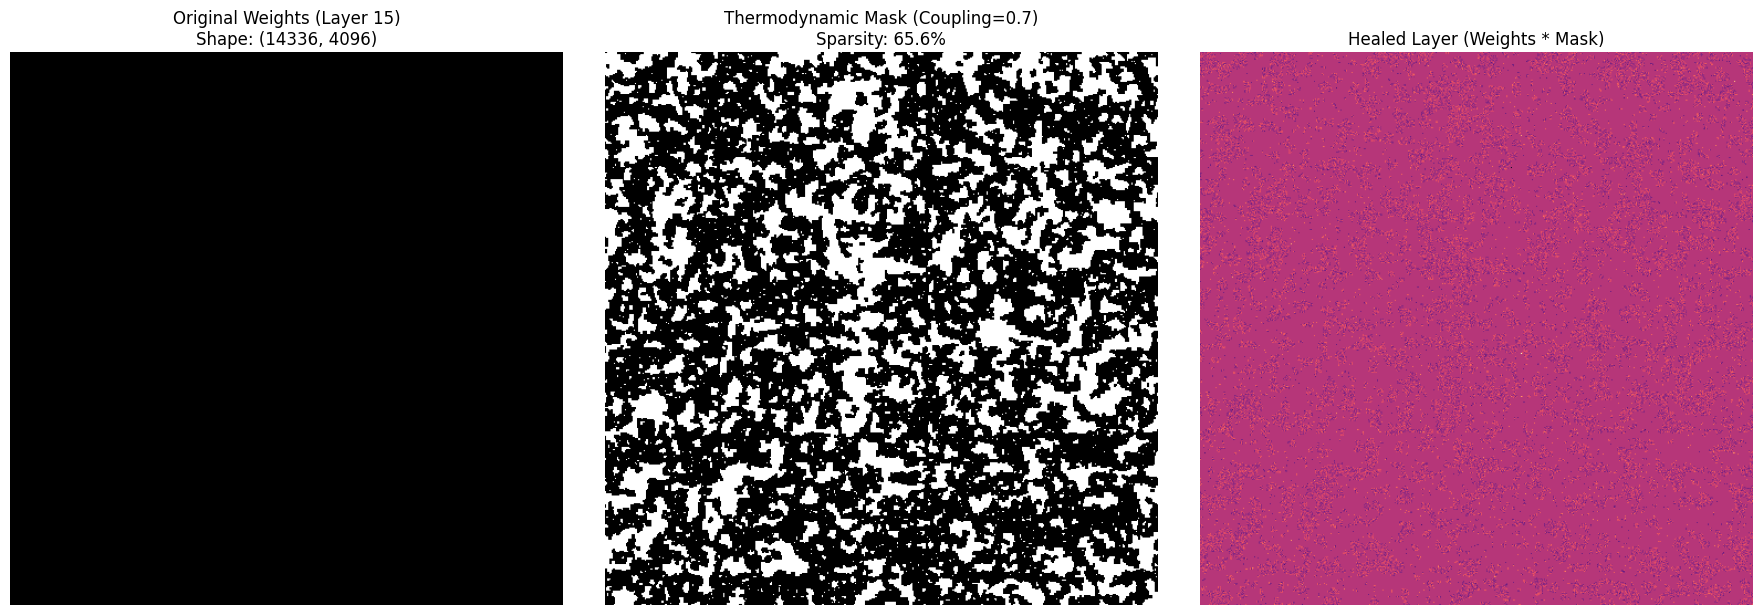

Mask saved to: layer_15_mask.npy


In [ ]:
# --- CELL 3 (FIXED): RUN AND VISUALIZE ---
import os
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from safetensors.flax import load_file

def find_and_load_layer(root_path, layer_idx=15, matrix="up_proj"):
    """
    Recursively finds the safetensors file containing the specific layer.
    """
    target_key = f"model.layers.{layer_idx}.mlp.{matrix}.weight"
    print(f"Searching for: {target_key}...")

    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith(".safetensors"):
                full_path = os.path.join(root, file)
                try:
                    # FIX: load_file returns a dict directly, not a context manager
                    data = load_file(full_path)

                    if target_key in data:
                        print(f"Found in: {file}")
                        # Convert to JAX array immediately
                        weight = jnp.array(data[target_key])
                        return weight

                    # Explicitly delete to free RAM if it's the wrong file
                    del data

                except Exception as e:
                    print(f"Error reading {file}: {e}")
                    continue

    raise ValueError(f"Layer {layer_idx} ({matrix}) not found in {root_path}")

# 1. LOAD
# Uses the model_path variable from Cell 1
raw_weights = find_and_load_layer(model_path, layer_idx=15, matrix="up_proj")

# 2. ANNEAL
# Coupling=0.7 enforces strong clustering (The 'Ising Landscape')
print(f"Starting Annealing on {raw_weights.shape}...")
final_spins, field = anneal_layer(raw_weights, steps=2500, coupling=0.7)

# 3. PROCESS RESULTS
final_mask = (final_spins > 0).astype(jnp.float32)
sparsity = 1.0 - jnp.mean(final_mask)
print(f"\nFINAL SPARSITY: {sparsity:.2%}")

# 4. VISUALIZATION (The Proof)
zoom = 500
plt.figure(figsize=(18, 6))

# A. Raw Weights
plt.subplot(1, 3, 1)
plt.title(f"Original Weights (Layer 15)\nShape: {raw_weights.shape}")
plt.imshow(raw_weights[:zoom, :zoom], cmap='gray', vmin=-0.1, vmax=0.1)
plt.axis('off')

# B. The Thermodynamic Mask
plt.subplot(1, 3, 2)
plt.title(f"Thermodynamic Mask (Coupling=0.7)\nSparsity: {sparsity:.1%}")
plt.imshow(final_mask[:zoom, :zoom], cmap='bone')
plt.axis('off')

# C. The Healed Intelligence
plt.subplot(1, 3, 3)
plt.title("Healed Layer (Weights * Mask)")
plt.imshow((raw_weights * final_mask)[:zoom, :zoom], cmap='magma', vmin=-0.1, vmax=0.1)
plt.axis('off')

plt.tight_layout()
plt.savefig("ising_landscape_layer15.png")
plt.show()

# 5. SAVE
np.save("layer_15_mask.npy", np.array(final_mask))
print("Mask saved to: layer_15_mask.npy")

Calculating Ising Clusters...
Calculating Random Clusters...

--- TOPOLOGICAL METRICS ---
Total Clusters (Ising):  406,054
Total Clusters (Random): 7,132,941
Max Cluster Size (Ising):  12,308 pixels
Max Cluster Size (Random): 94 pixels


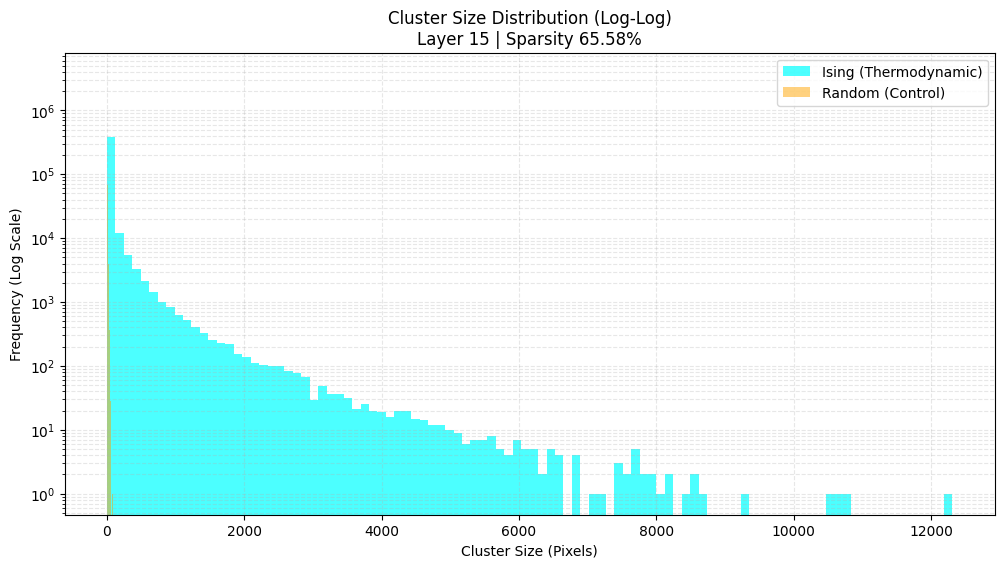

In [ ]:
# --- CELL 4: TOPOLOGICAL VALIDATION ---
from scipy.ndimage import label

def get_cluster_sizes(mask):
    """
    Counts how many distinct connected 'islands' of 1s exist,
    and how big each island is.
    Uses 4-connectivity (Up/Down/Left/Right).
    """
    # structure=[[0,1,0],[1,1,1],[0,1,0]] defines connectivity
    structure = np.array([[0,1,0], [1,1,1], [0,1,0]])
    labeled_array, num_features = label(mask, structure=structure)

    # Get sizes of every cluster
    # value_counts is slow for large arrays, so we use bincount
    sizes = np.bincount(labeled_array.ravel())

    # sizes[0] is the background (zeros), ignore it
    return sizes[1:]

# 1. GENERATE DUMMY RANDOM MASK (Control Group)
# Create a random mask with EXACTLY the same sparsity as our Ising result
target_sparsity = sparsity
random_mask = np.random.rand(*final_mask.shape) > target_sparsity

# 2. COMPUTE CLUSTERS
print("Calculating Ising Clusters...")
ising_sizes = get_cluster_sizes(np.array(final_mask))

print("Calculating Random Clusters...")
random_sizes = get_cluster_sizes(random_mask)

# 3. METRICS
print(f"\n--- TOPOLOGICAL METRICS ---")
print(f"Total Clusters (Ising):  {len(ising_sizes):,}")
print(f"Total Clusters (Random): {len(random_sizes):,}")
print(f"Max Cluster Size (Ising):  {np.max(ising_sizes):,} pixels")
print(f"Max Cluster Size (Random): {np.max(random_sizes):,} pixels")

# 4. PLOT (Log-Log Histogram)
plt.figure(figsize=(12, 6))
plt.hist(ising_sizes, bins=100, alpha=0.7, label='Ising (Thermodynamic)', color='cyan', log=True)
plt.hist(random_sizes, bins=100, alpha=0.5, label='Random (Control)', color='orange', log=True)
plt.title(f"Cluster Size Distribution (Log-Log)\nLayer 15 | Sparsity {sparsity:.2%}")
plt.xlabel("Cluster Size (Pixels)")
plt.ylabel("Frequency (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.savefig("topology_proof.png")
plt.show()

In [ ]:
# --- CELL 5: THE FULL MRI (ALL 32 LAYERS) ---
import json
import zipfile
import gc

# Configuration
TOTAL_LAYERS = 32
METRICS_LOG = {}
OUTPUT_DIR = "ising_masks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Starting Full Body Scan ({TOTAL_LAYERS} Layers)...")

for layer_idx in range(TOTAL_LAYERS):
    # 1. Clean Memory
    jax.clear_caches()
    gc.collect()

    try:
        print(f"\n--- PROCESSING LAYER {layer_idx} ---")

        # 2. Load Weights
        # We assume find_and_load_layer is defined from Cell 3
        # Note: Some early layers might be in shard 1, later in shard 2.
        # The function handles this automatically.
        weights = find_and_load_layer(model_path, layer_idx=layer_idx, matrix="up_proj")

        # 3. Anneal (The Physics)
        # We use the same coupling=0.7 to ensure structure
        spins, field = anneal_layer(weights, steps=2000, coupling=0.7)
        mask = (spins > 0).astype(np.uint8) # Save as uint8 to save space

        # 4. Metrics (The Science)
        sparsity = 1.0 - np.mean(mask)
        sizes = get_cluster_sizes(mask) # Uses function from Cell 4
        max_cluster = int(np.max(sizes)) if len(sizes) > 0 else 0

        print(f"Result: Sparsity {sparsity:.2%} | Max Cluster: {max_cluster}")

        # 5. Save Artifacts
        # Save Mask
        mask_filename = f"layer_{layer_idx:02d}_mask.npy"
        np.save(os.path.join(OUTPUT_DIR, mask_filename), mask)

        # Log Metrics
        METRICS_LOG[layer_idx] = {
            "sparsity": float(sparsity),
            "max_cluster_size": max_cluster,
            "total_clusters": int(len(sizes)),
            "mean_cluster_size": float(np.mean(sizes)) if len(sizes) > 0 else 0
        }

    except Exception as e:
        print(f"CRITICAL FAILURE on Layer {layer_idx}: {e}")
        # Continue to next layer so one failure doesn't kill the batch
        continue

# 6. Save Metrics Report
with open("ising_metrics.json", "w") as f:
    json.dump(METRICS_LOG, f, indent=4)

# 7. Zip Everything
print("\nScanning Complete. Zipping files...")
with zipfile.ZipFile("deepseek_ising_dataset.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(OUTPUT_DIR):
        for file in files:
            zipf.write(os.path.join(root, file), file)
    zipf.write("ising_metrics.json", "ising_metrics.json")

print("SUCCESS: deepseek_ising_dataset.zip is ready for download.")

Starting Full Body Scan (32 Layers)...

--- PROCESSING LAYER 0 ---
Searching for: model.layers.0.mlp.up_proj.weight...
Found in: model-00001-of-000002.safetensors
Loading Lattice: (14336, 4096) | Device: cuda:0
Annealing for 2000 steps on A100...
Step 0000 | Temp: 5.0000 | Pruned: 50.48%
Step 0200 | Temp: 4.5008 | Pruned: 50.32%
Step 0400 | Temp: 4.0015 | Pruned: 50.50%
Step 0600 | Temp: 3.5023 | Pruned: 50.79%
Step 0800 | Temp: 3.0030 | Pruned: 51.32%
Step 1000 | Temp: 2.5038 | Pruned: 52.39%
Step 1200 | Temp: 2.0045 | Pruned: 54.67%
Step 1400 | Temp: 1.5053 | Pruned: 58.97%
Step 1600 | Temp: 1.0060 | Pruned: 63.84%
Step 1800 | Temp: 0.5068 | Pruned: 66.05%
Result: Sparsity 66.35% | Max Cluster: 8574

--- PROCESSING LAYER 1 ---
Searching for: model.layers.1.mlp.up_proj.weight...
Found in: model-00001-of-000002.safetensors
Loading Lattice: (14336, 4096) | Device: cuda:0
Annealing for 2000 steps on A100...
Step 0000 | Temp: 5.0000 | Pruned: 50.49%
Step 0200 | Temp: 4.5008 | Pruned: 50.3